# MS033 Preprocess
10/02/2023

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/LFPAnalysis')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS033'
subj_format = ['edf']
subj_site = ['MSSM']


#### Import Data

In [6]:
edf_files = glob(f'{neural_dir}/{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [7]:
mne_data

<RawEDF | MS033_SWB.edf, 276 x 2596032 (2535.2 s), ~5.34 GB, data loaded>

In [8]:
mne_data.ch_names

['LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LplsF1',
 'LplsF2',
 'LplsF3',
 'LplsF4',
 'LplsF5',
 'LplsF6',
 'LplsF7',
 'LplsF8',
 'LplsF9',
 'LplsF10',
 'LplsF11',
 'LplsF12',
 'LplsF13',
 'LplsF14',
 'LplsF15',
 'LplsF16',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmOlF10',
 'LmOlF11',
 'LmOlF12',
 'LCMAG1',
 'LCMAG2',
 'LCMAG3',
 'LCMAG4',
 'LCMAG5',
 'LCMAG6',
 'LCMAG7',
 'LCMAG8',
 'LCMAG9',
 'LCMAG10',
 'LCMAG11',
 'LCMAG12',
 'LCMAG13',
 'LCMAG14',
 'LpCsP1',
 'LpCsP2',
 'LpCsP3',
 'LpCsP4',
 'LpCsP5',
 'LpCsP6',
 'LpCsP7',
 'LpCsP8',
 'LpCsP9',
 'LpCsP10',
 'LpCsP11',
 'LpCsP12',
 'LpCsP13',
 'LpCsP14',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHplT10',
 'LHplT

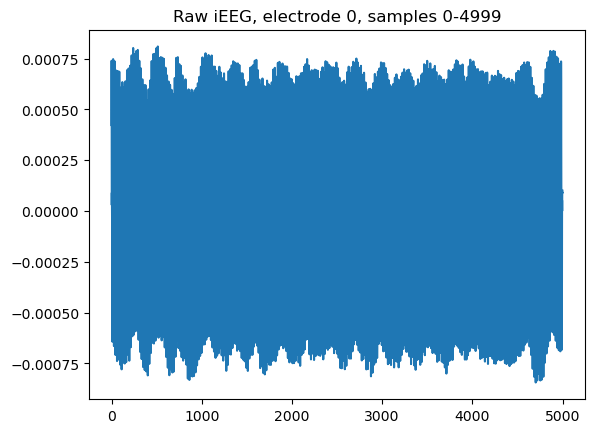

In [9]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

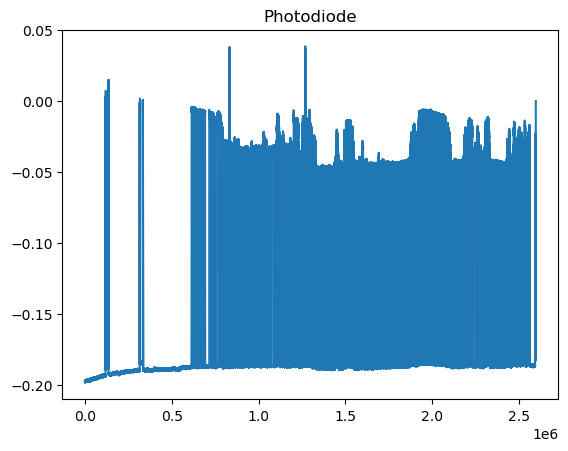

In [10]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [11]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x  \
0     LaCaS1    Unknown  -9.585032  42.333888  -0.799998 -10.782241   
1     LaCaS2    Unknown -11.581913  43.931393   3.600002 -12.877590   
2     LaCaS3    Unknown -13.179418  45.528898   8.000002 -14.567454   
3     LaCaS4    Unknown -14.776923  47.126404  12.400001 -16.392965   
4     LaCaS5    Unknown -16.773804  48.723909  16.800001 -18.683298   
..       ...        ...        ...        ...        ...        ...   
107   LpTpT6    A37lv_L -44.730144 -30.751981  -4.799998 -45.510707   
108   LpTpT7    A37vl_L -49.123283 -32.748863  -3.999998 -50.028291   
109   LpTpT8    A37vl_L -53.915798 -34.745745  -3.599998 -54.917713   
110   LpTpT9    A37vl_L -58.308937 -36.742626  -3.199998 -59.349167   
111  LpTpT10    A37dl_L -63.101452 -38.739508  -2.399998 -64.268801   

         mni_y      mni_z       gm                             NMM     Anat  \
0    32.248236  -6.253125    White      Left Cerebral White Matter  Unknown   
1    34.390400  -1.201499    White      Left Cerebral White Matter  Unknown   
2    36.479478   3.822967    White      Left Cerebral White Matter  Unknown   
3    38.506128   8.766578    White      Left Cerebral White Matter  Unknown   
4    40.561120  13.674981    White      Left Cerebral White Matter  Unknown   
..         ...        ...      ...                             ...      ...   
107 -48.556958  -5.939254    White      Left Cerebral White Matter  Unknown   
108 -50.775688  -5.212301    White      Left Cerebral White Matter  Unknown   
109 -53.045972  -5.105050     Gray  Left MTG middle temporal gyrus  Unknown   
110 -55.223633  -4.913593     Gray  Left MTG middle temporal gyrus  Unknown   
111 -57.403976  -4.280762  Unknown  Left MTG middle temporal gyrus  Unknown   

                     AnatMacro    BN246  \
0                        L ACC  Unknown   
1                      Unknown  Unknown   
2                      Unknown  Unknown   
3                      Unknown  Unknown   
4                      Unknown  Unknown   
..                         ...      ...   
107    L Middle Temporal Gyrus    L FuG   
108  L Inferior Temporal Gyrus    L ITG   
109  L Inferior Temporal Gyrus    L ITG   
110  L Inferior Temporal Gyrus    L ITG   
111    L Middle Temporal Gyrus    L MTG   

                                     YBA_1 ManualExamination Note  
0                                  Unknown                WM  NaN  
1                                  Unknown                WM  NaN  
2                                  Unknown                WM  NaN  
3                                  Unknown                WM  NaN  
4                                  Unknown                WM  NaN  
..                                     ...               ...  ...  
107                                Unknown                WM  NaN  
108                                Unknown                WM  NaN  
109  Left inferior middle temporal gyrus F                WM  NaN  
110  Left inferior middle temporal gyrus F               NaN  NaN  
111  Left inferior middle temporal gyrus F               OOB  NaN  

[112 rows x 16 columns]

In [12]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LAglT10',
 'LAglT11',
 'LAglT12',
 'LCMAG1',
 'LCMAG2',
 'LCMAG3',
 'LCMAG4',
 'LCMAG5',
 'LCMAG6',
 'LCMAG7',
 'LCMAG8',
 'LCMAG9',
 'LCMAG10',
 'LCMAG11',
 'LCMAG12',
 'LCMAG13',
 'LCMAG14',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmOlF10',
 'LmOlF11',
 'LmOlF12',
 'LpCsP1',
 'LpCsP2',
 'LpCsP3',
 'LpCsP4',
 'LpCsP5',
 'LpCsP6',
 'LpCsP7',
 'LpCsP8',
 'LpCsP9',
 'LpCsP10',
 'LpCsP11',
 'LpCsP12',
 'LpCsP13',
 'LpCsP14',
 'LpISF1',
 'LpISF2',
 'LpISF3'

In [13]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [14]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [15]:
new_name_dict


{'LmCmS1': 'lmcms1',
 'LmCmS2': 'lmcms2',
 'LmCmS3': 'lmcms3',
 'LmCmS4': 'lmcms4',
 'LmCmS5': 'lmcms5',
 'LmCmS6': 'lmcms6',
 'LmCmS7': 'lmcms7',
 'LmCmS8': 'lmcms8',
 'LmCmS9': 'lmcms9',
 'LmCmS10': 'lmcms10',
 'LplsF1': 'lpisf1',
 'LplsF2': 'lpisf2',
 'LplsF3': 'lpisf3',
 'LplsF4': 'lpisf4',
 'LplsF5': 'lpisf5',
 'LplsF6': 'lpisf6',
 'LplsF7': 'lpisf7',
 'LplsF8': 'lpisf8',
 'LplsF9': 'lpisf9',
 'LplsF10': 'lpisf10',
 'LplsF11': 'lpisf11',
 'LplsF12': 'lpisf12',
 'LplsF13': 'lpisf13',
 'LplsF14': 'lpisf14',
 'LplsF15': 'lpisf15',
 'LplsF16': 'lpisf16',
 'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LaCaS10': 'lacas10',
 'LaCaS11': 'lacas11',
 'LaCaS12': 'lacas12',
 'LmOlF1': 'lmolf1',
 'LmOlF2': 'lmolf2',
 'LmOlF3': 'lmolf3',
 'LmOlF4': 'lmolf4',
 'LmOlF5': 'lmolf5',
 'LmOlF6': 'lmolf6',
 'LmOlF7': 'lmolf7',
 'LmOlF8': 'lmolf8',
 'LmOlF9': '

In [16]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS033_SWB.edf, 276 x 2596032 (2535.2 s), ~5.34 GB, data loaded>

In [17]:
unmatched_seeg #make sure there are no unmatched names


[]

In [18]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c113', 'c114', 'c115', 'c116', 'c117', 'c118', 'c119', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c150', 'c151', 'c152', 'c153', 'c154', 'c155', 'c156', 'c157', 'c158', 'c159', 'c160', 'c161', 'c162', 'c163', 'c164', 'c165', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c2

In [19]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 112 left & 0 right sEEG electrodes
We have a total of 112 sEEG electrodes


In [20]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['c231',
 'c128',
 't5',
 'c236',
 'c213',
 'o2',
 'cz',
 'c116',
 'c124',
 'c188',
 'dc11',
 'c252',
 'c183',
 'c234',
 'c176',
 'c237',
 'c187',
 'c182',
 't4',
 'c155',
 'c168',
 'c239',
 'c232',
 'c152',
 'c123',
 'pleth',
 'c233',
 'c247',
 'c171',
 'c225',
 'fp2',
 'c203',
 'o1',
 'c216',
 'dc16',
 'c154',
 'c194',
 'c223',
 'c253',
 'c119',
 'c127',
 'c175',
 'c181',
 'c244',
 'c208',
 'c243',
 'c251',
 'f7',
 't6',
 'fp1',
 'c166',
 'c205',
 'c180',
 'f8',
 'c227',
 'c226',
 'c215',
 'c218',
 'c193',
 'c255',
 'c242',
 'c204',
 'c162',
 'c248',
 'c169',
 'c167',
 'c172',
 'c222',
 'c199',
 'c164',
 'c165',
 'trig',
 'pz',
 'dc3',
 'dc6',
 'dc8',
 'f3',
 'dc5',
 'dc2',
 'c214',
 'dc15',
 'c224',
 'c235',
 'c195',
 'c177',
 'c153',
 'c125',
 'c173',
 'c212',
 'pr',
 'c246',
 'c210',
 'c126',
 'c185',
 'c198',
 'c206',
 'c113',
 'c202',
 'c151',
 'dc14',
 'dc13',
 'c207',
 'c170',
 'c190',
 'c191',
 'c241',
 'c156',
 'c220',
 'c178',
 'c163',
 'c201',
 'c174',
 'c196',
 't3',
 'ek

In [21]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS033_SWB.edf, 113 x 2596032 (2535.2 s), ~2.19 GB, data loaded>

In [22]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} 
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS033_SWB.edf, 113 x 2596032 (2535.2 s), ~2.19 GB, data loaded>

In [23]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS033_SWB.edf, 113 x 2596032 (2535.2 s), ~2.19 GB, data loaded>

### Notch filter line noise

In [24]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:    6.6s finished


<RawEDF | MS033_SWB.edf, 113 x 2596032 (2535.2 s), ~2.19 GB, data loaded>

### Resampling data 

In [25]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    7.9s finished


<RawEDF | MS033_SWB.edf, 113 x 1267594 (2535.2 s), ~1.07 GB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [26]:
mne_data.save(f'{neural_dir}/{subj_id}/photodiode.fif', picks='dc1', overwrite=True)

In [27]:
mne_data.drop_channels('dc1')

<RawEDF | MS033_SWB.edf, 112 x 1267594 (2535.2 s), ~1.06 GB, data loaded>

### Bad Channel Removal (automated + manual inspection)

In [74]:
### I skip this step because it doesn't work for me 

# bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
# bads
# mne_data.info['bads'] = bads
#9/26/23 - too strict, manually overriding 

In [25]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [26]:
probe_names

array(['lacas', 'lagit', 'laims', 'lhplt', 'lloif', 'lmoif', 'lpips',
       'lsif', 'racas', 'ragit', 'raims', 'rhplt', 'rmoif'], dtype='<U5')

In [27]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [28]:
probe_ch_counts

{'lacas': 12,
 'lagit': 10,
 'laims': 14,
 'lhplt': 12,
 'lloif': 10,
 'lmoif': 14,
 'lpips': 14,
 'lsif': 8,
 'racas': 14,
 'ragit': 12,
 'raims': 14,
 'rhplt': 12,
 'rmoif': 12}

<IPython.core.display.Javascript object>


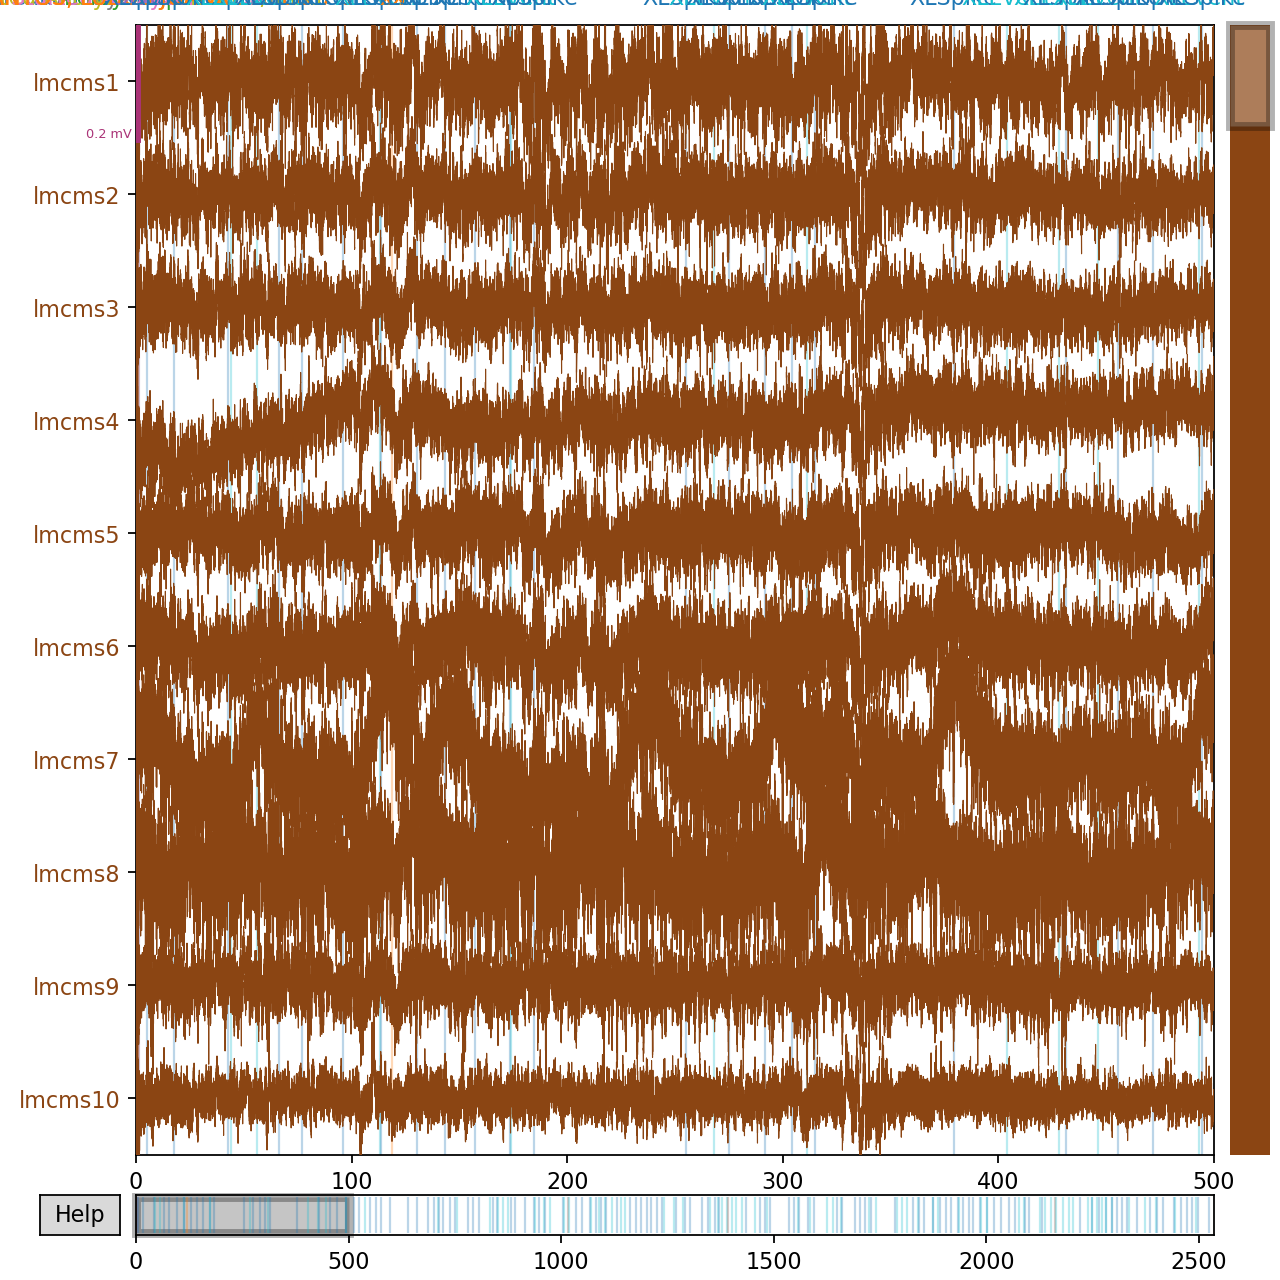

<IPython.core.display.Javascript object>


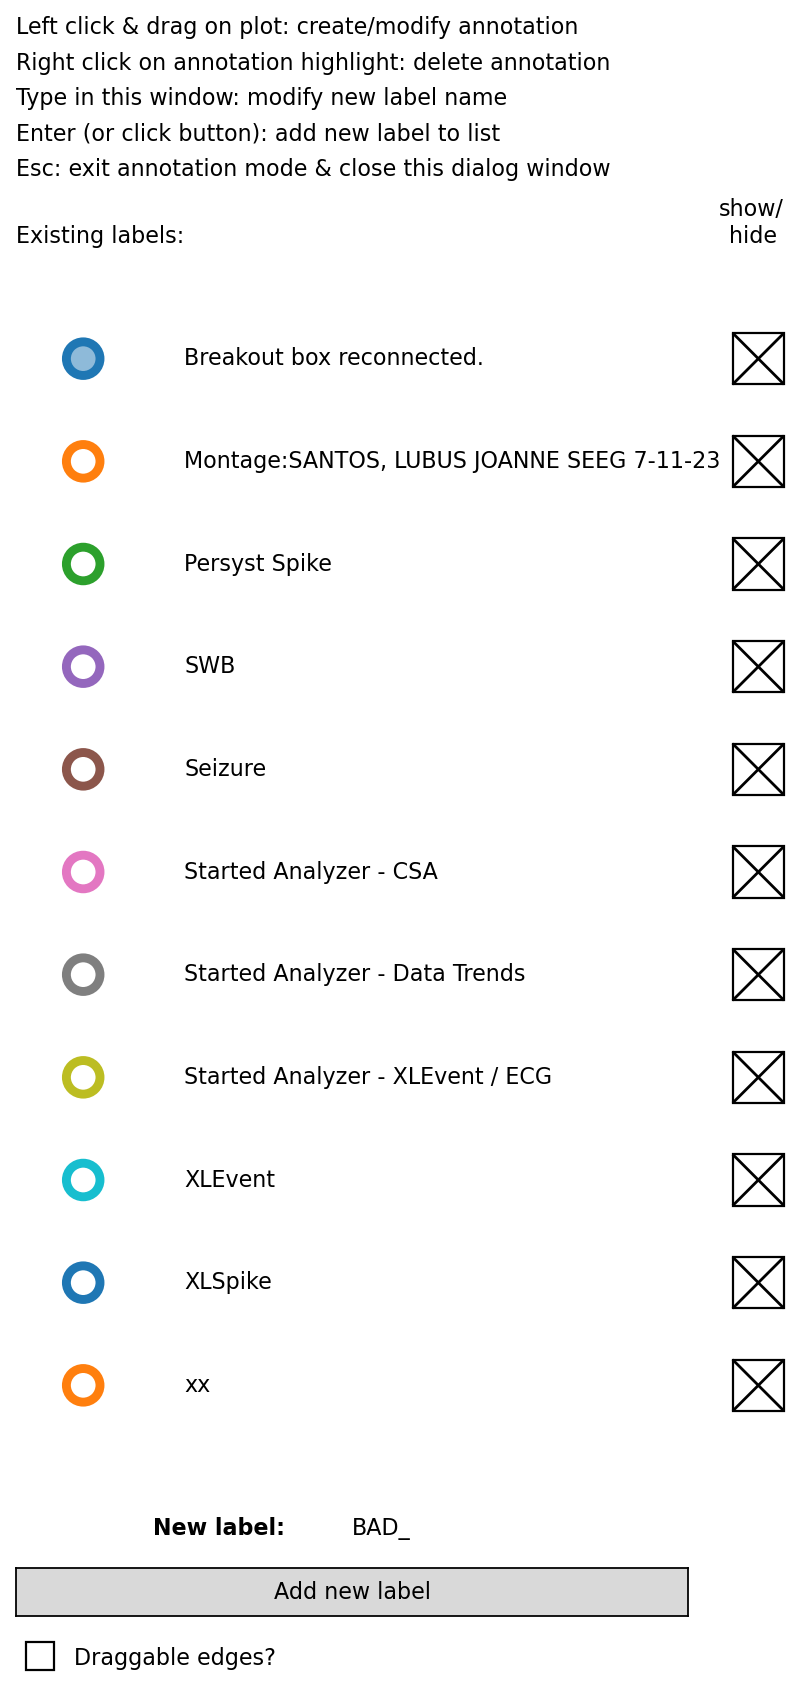

In [29]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10)
fig.fake_keypress('a')

<IPython.core.display.Javascript object>


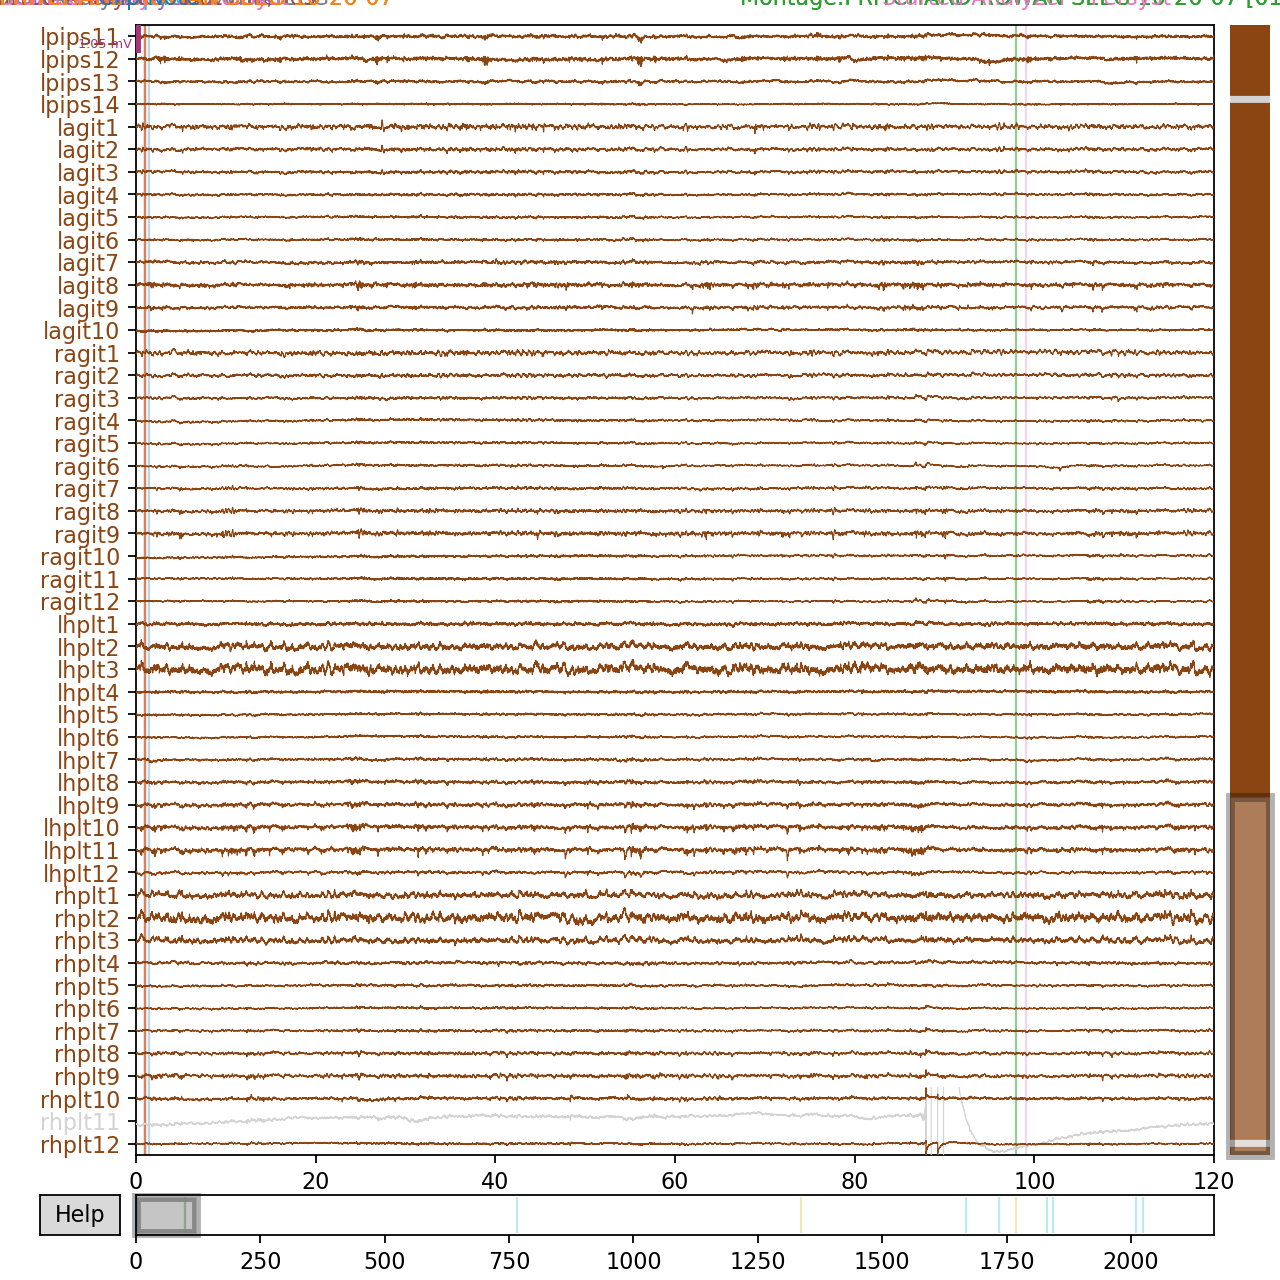

<IPython.core.display.Javascript object>


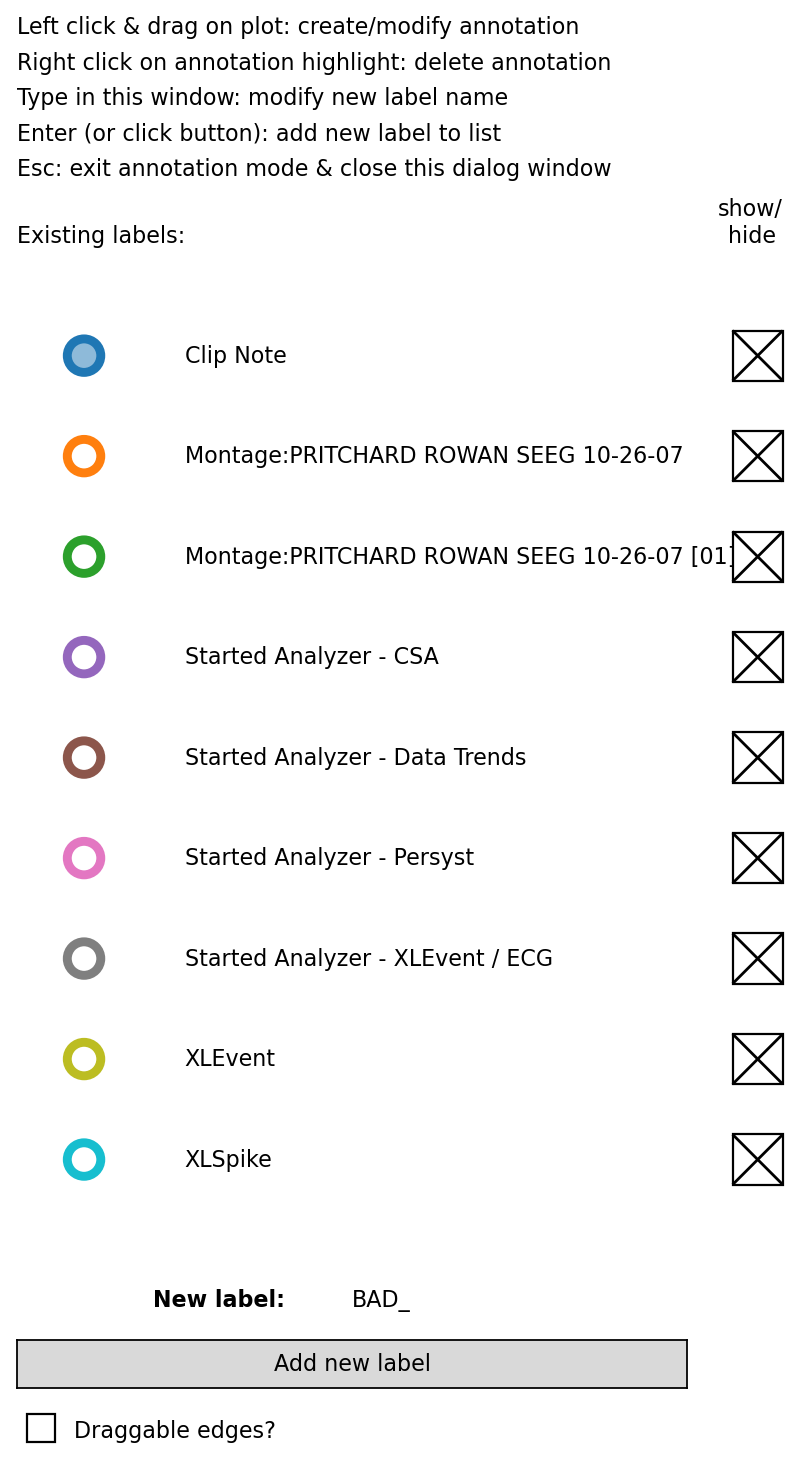

In [34]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [35]:
mne_data.info['bads'] = ['lmoif1', 'rhplt11']

In [107]:
#if plot is being buggy - manually set bads

#ms002_bad_ch = ['rhplt11', 'lmoif1']
#mne_data.info['bads'] = ms002_bad_ch 

In [36]:
mne_data.info['bads']

['lmoif1', 'rhplt11']

In [36]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 2 items (lmoif1, rhplt11)
 ch_names: lloif1, lloif2, lloif3, lloif4, lloif5, lloif6, lloif7, lloif8, ...
 chs: 158 sEEG
 custom_ref_applied: False
 dig: 158 items (158 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 15:59:08 UTC
 nchan: 158
 projs: []
 sfreq: 500.0 Hz
>

## Save raw LFP data
Notch filtered and resampled with bad elecs indicated

In [30]:
#define oob elecs as bad before saving out lfp file 
oob_elec = [elec_locs['label'].iloc[ind].lower() for ind, data in elec_locs['ManualExamination'].str.lower().items() if data=='oob']
oob_elec

['lacas10',
 'lacas11',
 'lacas12',
 'laglt11',
 'laglt12',
 'lcmag14',
 'lhplt10',
 'lhplt11',
 'lhplt12',
 'lmcms4',
 'lmcms10',
 'lmolf10',
 'lmolf12',
 'lpcsp13',
 'lpcsp14',
 'lpisf10',
 'lpisf15',
 'lpisf16',
 'lptpt10']

In [42]:
bad_ch= ['rhplt11', 'lmoif1'] #or =mne_data.info['bads']
bad_ch = bad_ch + oob_elec
mne_data.info['bads'] = bad_ch
mne_data.info['bads']

['rhplt11',
 'lmoif1',
 'lacas11',
 'lacas12',
 'lagit10',
 'lloif5',
 'lmoif14',
 'lpips14',
 'racas10',
 'racas11',
 'racas14',
 'ragit11',
 'ragit12',
 'raims5',
 'rhplt12',
 'rmoif11',
 'rmoif12']

In [31]:
mne_data.save(f'{neural_dir}/{subj_id}/raw_ieeg.fif',overwrite=True)

# Rereference data - Both WM ref and Bipolar ref!

In [7]:
# mne_data = mne.io.read_raw_fif(f'{neural_dir}/{subj_id}/raw_ieeg.fif')

In [9]:
elec_locs.ManualExamination

0      NaN
1      NaN
2      OOB
3      OOB
4      NaN
      ... 
153     WM
154    NaN
155    NaN
156    NaN
157    NaN
Name: ManualExamination, Length: 158, dtype: object

### WM REF

In [32]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [33]:
mne_data_wm_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [ ]:
mne_data_reref.drop_channels([x for x in mne_data_reref.ch_names if '-' not in x])

In [45]:
mne_data_wm_reref.ch_names

['lloif5',
 'lloif6',
 'lmoif4',
 'lmoif7',
 'lmoif14',
 'rmoif5',
 'rmoif11',
 'rmoif12',
 'lacas9',
 'lacas11',
 'lacas12',
 'racas4',
 'racas5',
 'racas10',
 'racas11',
 'racas14',
 'laims7',
 'laims8',
 'laims9',
 'raims5',
 'raims7',
 'raims9',
 'raims10',
 'lsif3',
 'lsif5',
 'lpips5',
 'lpips7',
 'lpips9',
 'lpips14',
 'lagit6',
 'lagit8',
 'lagit10',
 'ragit5',
 'ragit11',
 'ragit12',
 'lhplt5',
 'lhplt6',
 'rhplt4',
 'rhplt5',
 'rhplt7',
 'rhplt12',
 'lacas1-lmoif3',
 'lacas10-laims14',
 'lacas2-lmoif5',
 'lacas3-lmoif5',
 'lacas4-lmoif5',
 'lacas5-lmoif6',
 'lacas6-laims10',
 'lacas7-laims10',
 'lacas8-laims14',
 'lagit1-lagit5',
 'lagit2-lagit5',
 'lagit3-lagit5',
 'lagit4-lagit5',
 'lagit7-lagit5',
 'lagit9-lagit5',
 'laims1-lloif4',
 'laims11-laims14',
 'laims12-laims14',
 'laims13-lpips12',
 'laims2-lloif4',
 'laims3-lloif4',
 'laims4-lloif4',
 'laims5-lsif1',
 'laims6-lsif1',
 'lhplt1-lagit5',
 'lhplt10-lhplt8',
 'lhplt11-lhplt8',
 'lhplt12-lhplt8',
 'lhplt2-lagit5',
 'l

<IPython.core.display.Javascript object>


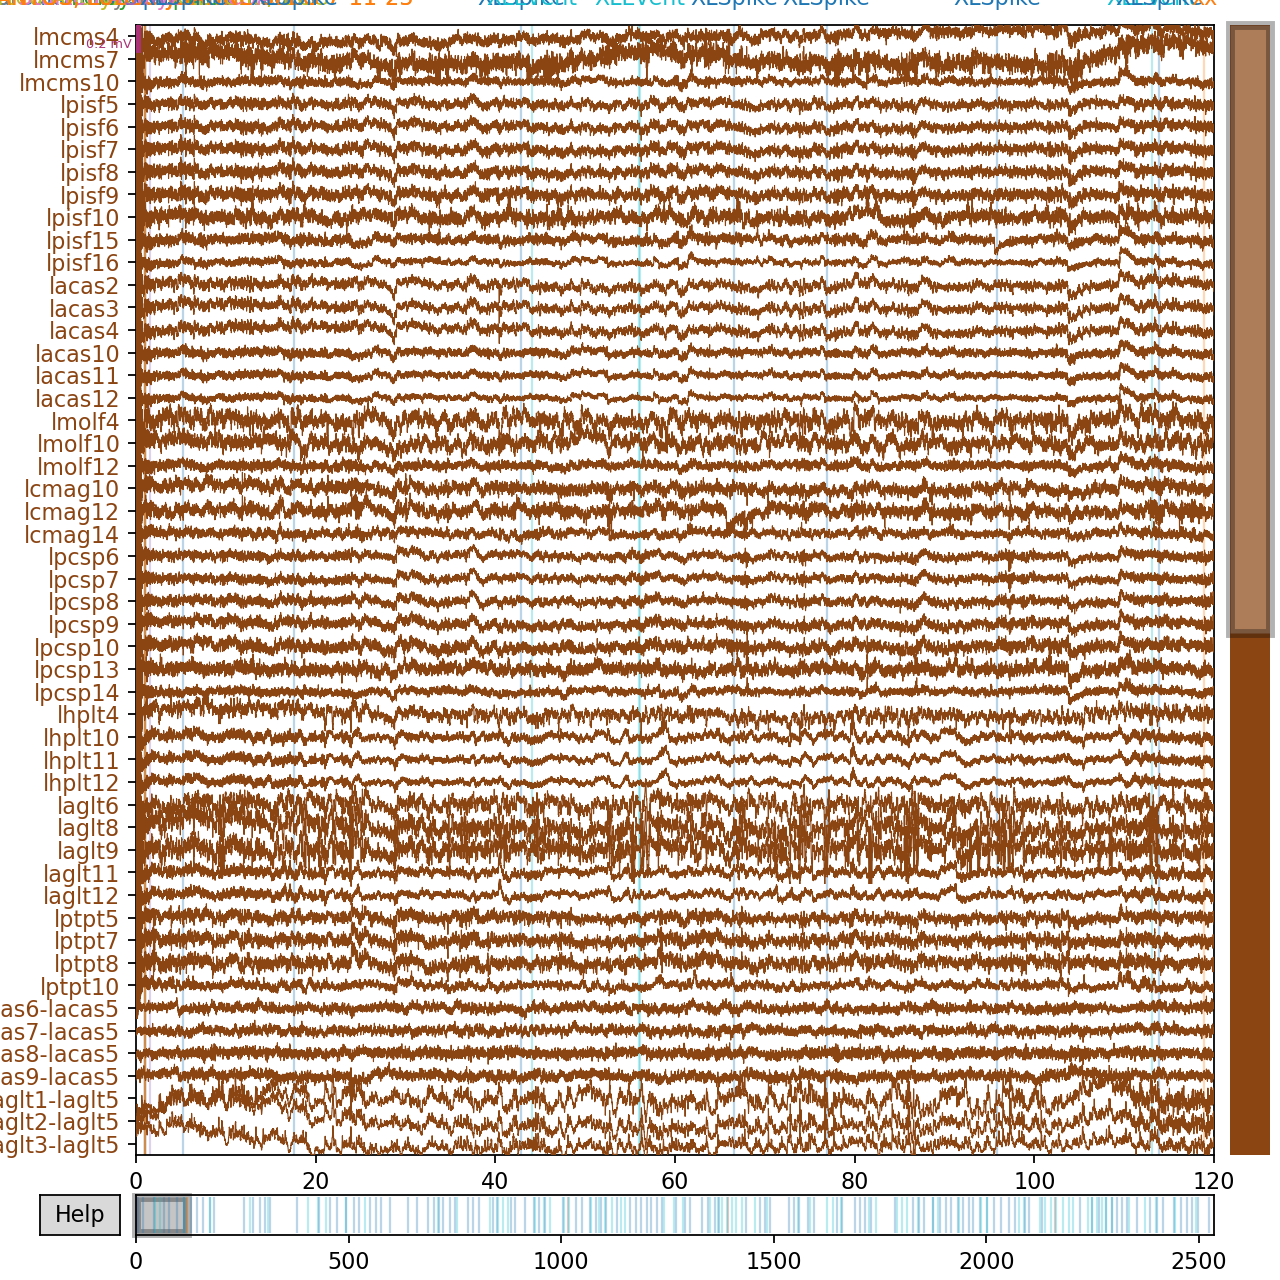

<IPython.core.display.Javascript object>


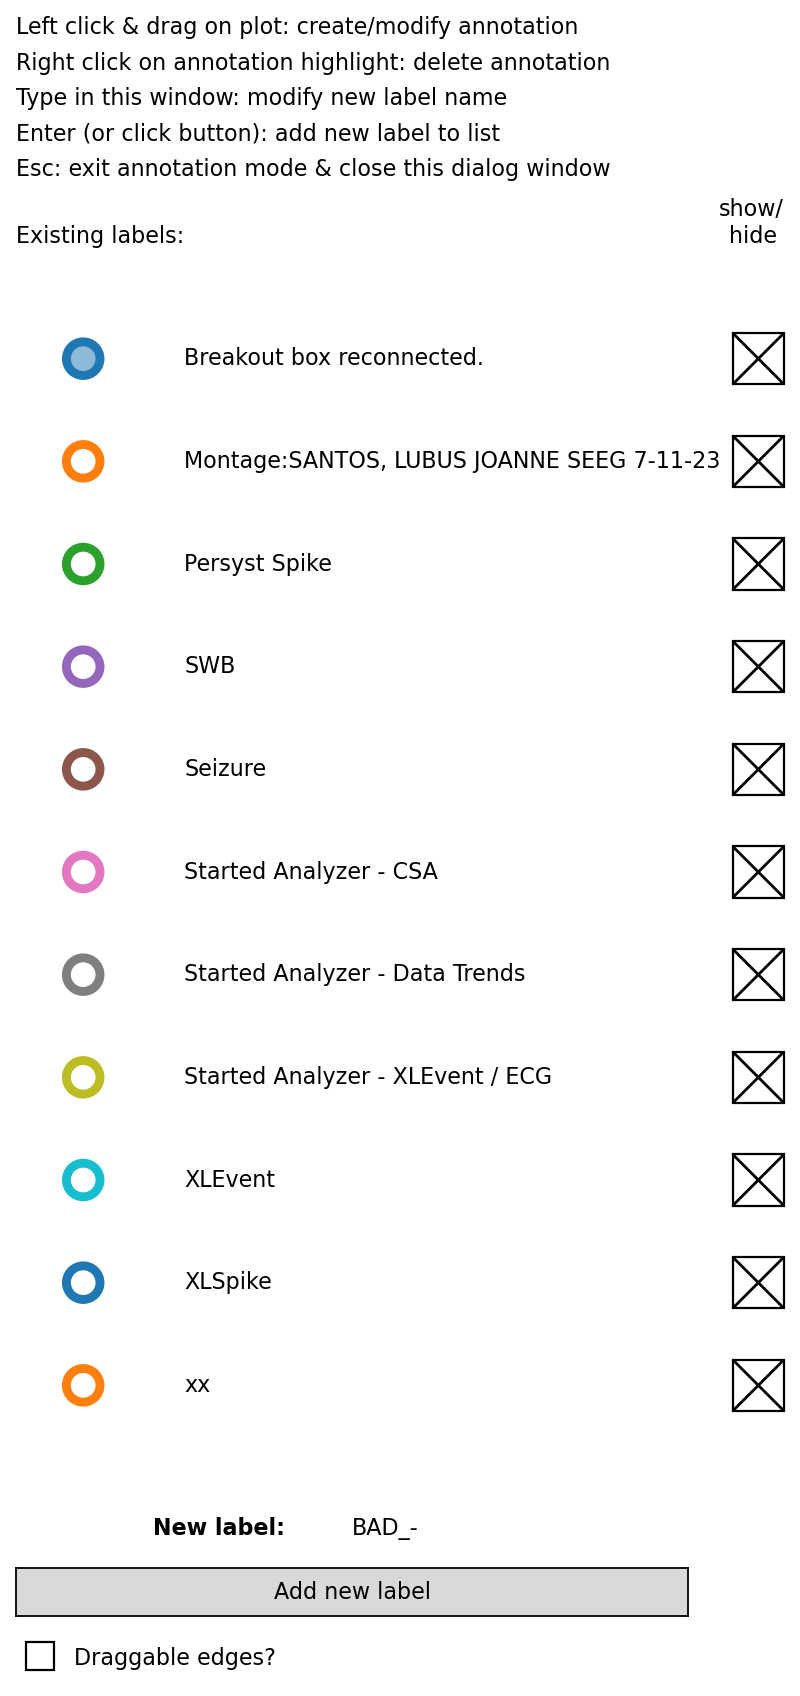

In [36]:
%matplotlib notebook
%matplotlib notebook

fig = mne_data_wm_reref.plot(start=0, duration=120, n_channels=50)
fig.fake_keypress('a')

###  BIPOLAR REF

In [37]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.bipolar_ref(elec_path=anat_file, 
                                       bad_channels=mne_data.info['bads'], 
                                       unmatched_seeg=unmatched_seeg,
                                       site='MSSM')

In [38]:
mne_data_bp_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [39]:
mne_data_bp_reref

<RawEDF | MS033_SWB.edf, 103 x 1267594 (2535.2 s), ~996.3 MB, data loaded>

<IPython.core.display.Javascript object>


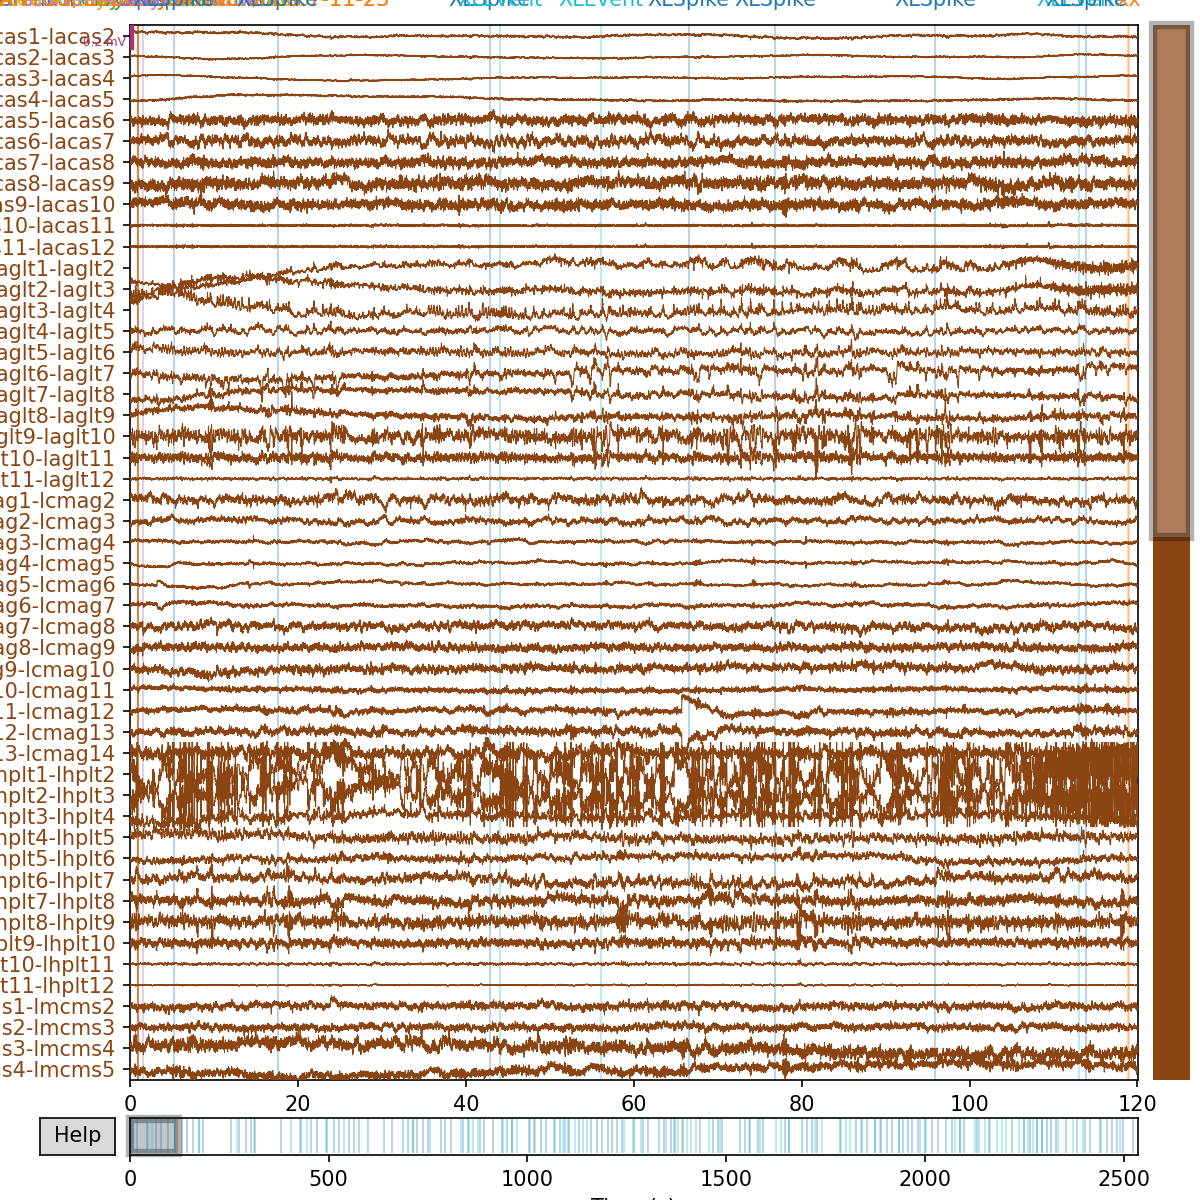

<IPython.core.display.Javascript object>


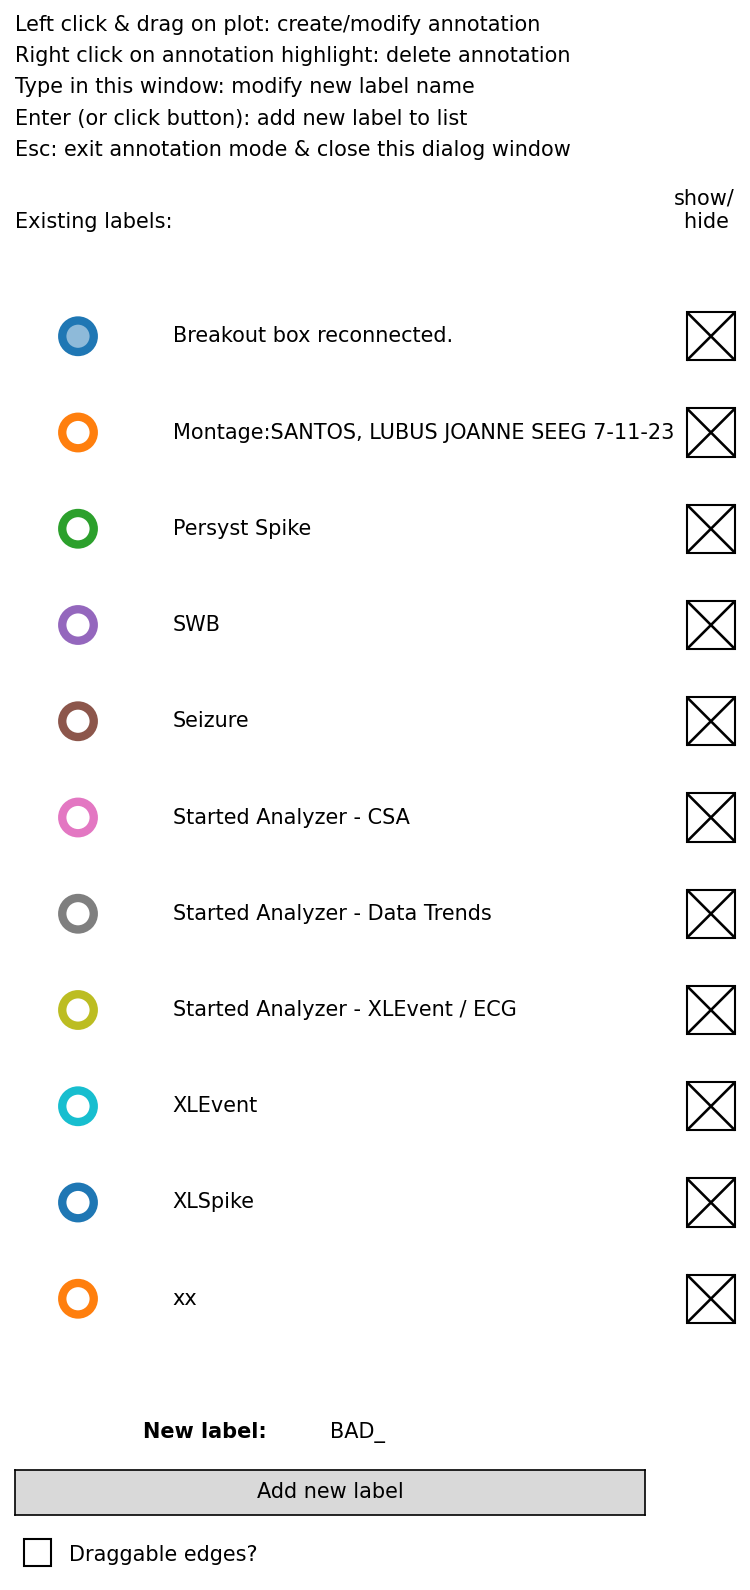

In [41]:
%matplotlib notebook
%matplotlib notebook

fig = mne_data_bp_reref.plot(start=0, duration=120, n_channels=50)
fig.fake_keypress('a')

## Save reref data

In [99]:
mne_data_wm_reref.save(f'{neural_dir}/MS002/wm_ref_ieeg.fif',overwrite=True)

In [100]:
mne_data_bp_reref.save(f'{neural_dir}/MS002/bp_ref_ieeg.fif',overwrite=True)